In [1]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras as keras
import matplotlib.pyplot as plt

In [2]:
def load_data(data_path):

    with open(data_path, 'r') as fp:
        data = json.load(fp)

    X = np.array(data['mfcc'])
    y = np.array(data['species'])

    return X, y

In [3]:
def prepare_datasets(test_size, validation_size):
    
    X, y = load_data(dataset_path)

    label_encoder = LabelEncoder()
    label_encoder.fit(y)
    new_y = label_encoder.transform(y)
    new_y = new_y.reshape(-1, 1)

    X_train, X_test, y_train, y_test = train_test_split(X, new_y, test_size = test_size)

    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = validation_size)
    
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [8]:
def build_model(input_shape):
    # sequential model
    model = keras.Sequential()
    # input layer
    model.add(keras.layers.Conv2D(32, (2, 2), input_shape=input_shape, activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides = (2, 2), padding = 'same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.2))
    # second convolutional layer
    model.add(keras.layers.Conv2D(128, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides = (2, 2), padding = 'same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.2))
    # third convolutional layer
    model.add(keras.layers.Conv2D(128, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides = (2, 2), padding = 'same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.2))
    # fourth convolutional layer
    model.add(keras.layers.Conv2D(64, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides = (2, 2), padding = 'same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.GlobalAveragePooling2D())
    # flatten/dense layer    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation = 'relu'))
    model.add(keras.layers.Dropout(0.2))
    # output layer
    model.add(keras.layers.Dense(49, activation='softmax'))

    return model

In [5]:
def plot_history(history):
    
    fig, axis = plt.subplots(2)
    axis[0].plot(history.history['accuracy'], label = 'train accuracy')
    axis[0].plot(history.history['val_accuracy'], label = 'validation accuracy')
    axis[0].set_ylabel("Accuracy")
    axis[0].legend(loc = 'lower right')
    axis[0].set_title('Accuracy Eval')
    
    axis[1].plot(history.history['loss'], label = 'train error')
    axis[1].plot(history.history['val_loss'], label = 'validation error')
    axis[1].set_ylabel("Error")
    axis[1].set_ylabel('Epoch')
    axis[1].legend(loc = 'upper right')
    axis[1].set_title('Error Eval')
    
    plt.show()

In [6]:
def predict(model, X, y):

    X = X[np.newaxis, ...]
    prediction = model.predict(X)
    predictions = model.predict_classes(X)
    predicted_index = np.argmax(prediction, axis = 1)
    print(prediction)
    print(predictions)
    print('Expected index: {}, Predicted index:{}'.format(y, predicted_index))

In [7]:
dataset_path = 'c:/users/ktauf/documents/github/finalproject_data_files/data_1segment_26mfccs.json'


Train on 1260 samples, validate on 316 samples
Epoch 1/100
1260/1260 - 64s - loss: 3.7735 - accuracy: 0.0706 - val_loss: 4.1371 - val_accuracy: 0.0411
Epoch 2/100
1260/1260 - 47s - loss: 3.4702 - accuracy: 0.1429 - val_loss: 3.7540 - val_accuracy: 0.0918
Epoch 3/100
1260/1260 - 48s - loss: 3.2654 - accuracy: 0.1952 - val_loss: 3.5201 - val_accuracy: 0.1297
Epoch 4/100
1260/1260 - 47s - loss: 3.0589 - accuracy: 0.2429 - val_loss: 3.3310 - val_accuracy: 0.1709
Epoch 5/100
1260/1260 - 47s - loss: 2.8873 - accuracy: 0.2762 - val_loss: 3.0815 - val_accuracy: 0.2152
Epoch 6/100
1260/1260 - 47s - loss: 2.7342 - accuracy: 0.2937 - val_loss: 2.9096 - val_accuracy: 0.2627
Epoch 7/100
1260/1260 - 48s - loss: 2.5565 - accuracy: 0.3381 - val_loss: 2.7938 - val_accuracy: 0.3101
Epoch 8/100
1260/1260 - 47s - loss: 2.3751 - accuracy: 0.3944 - val_loss: 2.6858 - val_accuracy: 0.3070
Epoch 9/100
1260/1260 - 47s - loss: 2.2634 - accuracy: 0.3992 - val_loss: 2.4852 - val_accuracy: 0.3797
Epoch 10/100
1260

Epoch 79/100
1260/1260 - 47s - loss: 0.1474 - accuracy: 0.9579 - val_loss: 1.7868 - val_accuracy: 0.6772
Epoch 80/100
1260/1260 - 47s - loss: 0.1451 - accuracy: 0.9603 - val_loss: 1.7746 - val_accuracy: 0.6551
Epoch 81/100
1260/1260 - 47s - loss: 0.1658 - accuracy: 0.9540 - val_loss: 1.8092 - val_accuracy: 0.6582
Epoch 82/100
1260/1260 - 47s - loss: 0.1855 - accuracy: 0.9413 - val_loss: 2.2566 - val_accuracy: 0.5791
Epoch 83/100
1260/1260 - 47s - loss: 0.1739 - accuracy: 0.9548 - val_loss: 1.7954 - val_accuracy: 0.6741
Epoch 84/100
1260/1260 - 47s - loss: 0.1861 - accuracy: 0.9405 - val_loss: 1.7984 - val_accuracy: 0.6297
Epoch 85/100
1260/1260 - 47s - loss: 0.1474 - accuracy: 0.9579 - val_loss: 1.7909 - val_accuracy: 0.6962
Epoch 86/100
1260/1260 - 47s - loss: 0.1546 - accuracy: 0.9548 - val_loss: 1.8394 - val_accuracy: 0.6487
Epoch 87/100
1260/1260 - 47s - loss: 0.1581 - accuracy: 0.9563 - val_loss: 1.7138 - val_accuracy: 0.6994
Epoch 88/100
1260/1260 - 47s - loss: 0.1653 - accuracy:

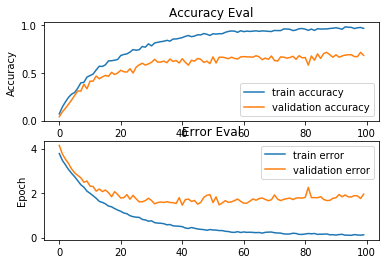

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1291, 25, 32)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 646, 13, 32)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 646, 13, 32)       128       
_________________________________________________________________
dropout (Dropout)            (None, 646, 13, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 645, 12, 128)      16512     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 323, 6, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 323, 6, 128)       5

In [9]:
if __name__ == '__main__':

    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
    model = build_model(input_shape)

    optimizer = keras.optimizers.Adam(learning_rate = 0.001)
    model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

    history = model.fit(X_train, y_train, validation_data = (X_validation, y_validation),
                        batch_size = 32, epochs = 100, verbose = 2)
    
    plot_history(history)
    
    model.summary()
    

In [10]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose = 2)

526/526 - 6s - loss: 2.0509 - accuracy: 0.6483


In [11]:
X = X_test[300]
y = y_test[300]
predict(model, X, y)

[[2.10422977e-12 1.87384934e-11 1.97272989e-08 1.21985581e-11
  3.26156074e-10 9.21921219e-06 4.72879733e-15 1.60408113e-08
  2.18220168e-12 6.89538338e-09 2.94598195e-08 4.10989372e-07
  2.55241158e-11 2.54613431e-11 1.35348573e-05 8.27605724e-01
  4.59685241e-11 1.27042574e-06 4.83043152e-08 2.99120000e-11
  6.44349075e-06 2.05059546e-11 1.70714956e-10 4.47872708e-06
  4.73556589e-08 3.60177305e-10 1.07028175e-09 1.67839810e-01
  1.07117666e-08 3.03557499e-08 3.88039947e-11 1.58753913e-11
  2.10695503e-10 1.08878995e-09 2.88926607e-08 1.69521471e-07
  7.56446923e-08 4.69996125e-11 2.59201691e-08 1.99957541e-03
  1.54566626e-12 1.15482436e-10 4.36820891e-09 1.02385329e-07
  7.84913664e-06 2.37428653e-03 2.07017436e-07 2.06342428e-08
  1.36608345e-04]]
[15]
Expected index: [15], Predicted index:[15]


In [12]:
# save model
model.save('cnn_66_trained.h5')